HRV Time-Domain Metrics:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  771.527778  39.143263         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  47.304031  47.468617  ...       59.5     0.827483   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        740.6        804.4  43.055556  70.138889      659.0      864.0   

    HRV_HTI  HRV_TINN  
0  7.578947  148.4375  

[1 rows x 25 columns]

HRV Frequency-Domain Metrics:
   HRV_ULF  HRV_VLF    HRV_LF    HRV_HF  HRV_VHF   HRV_TP  HRV_LFHF   HRV_LFn  \
0      NaN      NaN  0.034162  0.027607  0.01498  0.07675  1.237435  0.445111   

    HRV_HFn  HRV_LnHF  
0  0.359704 -3.589676  

HRV Non-Linear Metrics:
     HRV_SD1    HRV_SD2  HRV_SD1SD2        HRV_S   HRV_CSI   HRV_CVI  \
0  33.565381  43.836342    0.765698  4622.487583  1.305999  4.371846   

   HRV_CSI_Modified   HRV_P

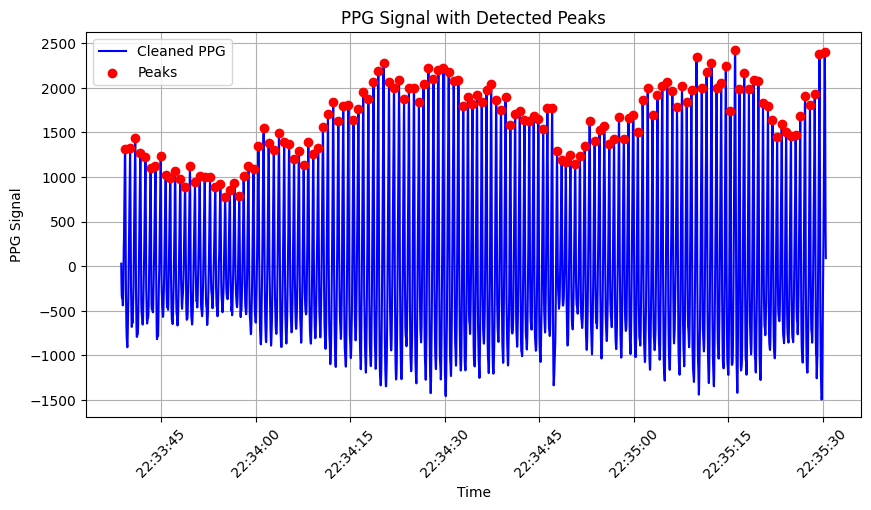

In [21]:
# 필요 라이브러리 임포트
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np

# 기존 Firebase 앱이 있으면 삭제하고 새로 초기화
if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# Firebase 앱 초기화 (사용자의 키와 URL로 수정 필요)
cred = credentials.Certificate("hrv-data-a12d2-firebase-adminsdk-fbsvc-d6a2051332.json")
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrv-data-a12d2-default-rtdb.firebaseio.com/"})

# 데이터 가져오기
ref = db.reference("HeartRateData")
data = ref.get()

# 데이터 정리
ppg_values = []
timestamps = []

for key, value in data.items():
    if not value["isError"]:  # 오류 없는 데이터만 사용
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성 및 정렬
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")

# 초반 2초 데이터 삭제
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 청소 (샘플링 주파수 25Hz)
fs = 25
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# 피크 검출 함수 (min_y 추가)
def find_prominent_peaks(signal, threshold=0.1, min_y=0):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > min_y:
            left_min = min(signal[max(0, i - 5):i])
            right_min = min(signal[i + 1:i + 6])
            prominence = signal[i] - max(left_min, right_min)
            if prominence > threshold:
                peaks.append(i)
    return peaks

# 피크 검출
min_y = 0
peaks_indices = find_prominent_peaks(ppg_cleaned, threshold=0.1, min_y=min_y)

# 피크의 타임스탬프와 값 추출
peaks_timestamps = df["Timestamp"].iloc[peaks_indices].values
peaks_values = ppg_cleaned[peaks_indices]

# RR 간격 계산 (밀리초 단위)
rr_intervals = np.diff(peaks_timestamps).astype('timedelta64[ms]').astype(int)

# RR 간격을 다시 피크 인덱스로 변환
peaks_from_rr = nk.intervals_to_peaks(rr_intervals)

# HRV 도메인별 분석
hrv_time_metrics = nk.hrv_time(peaks_from_rr, sampling_rate=1000)
hrv_frequency_metrics = nk.hrv_frequency(peaks_from_rr, sampling_rate=1000)
hrv_nonlinear_metrics = nk.hrv_nonlinear(peaks_from_rr, sampling_rate=1000)

# HRV 지표 출력
print("HRV Time-Domain Metrics:")
print(hrv_time_metrics)
print("\nHRV Frequency-Domain Metrics:")
print(hrv_frequency_metrics)
print("\nHRV Non-Linear Metrics:")
print(hrv_nonlinear_metrics)


# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks_timestamps, peaks_values, color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()


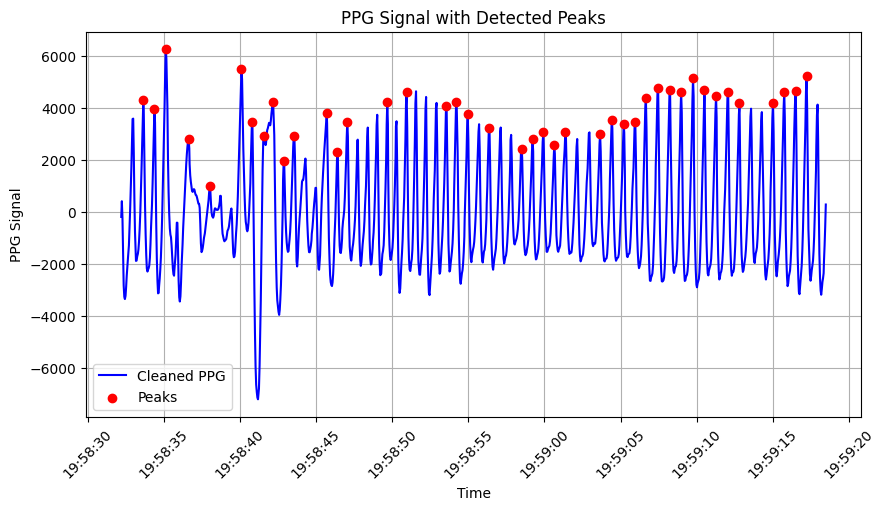

In [29]:
# neourokit2를 사용해 peak를 구하는 함수 peak는 정확하지만 탐지하지 못하는 peak가 있음
# 필요 라이브러리 임포트
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

if firebase_admin._apps:
    firebase_admin.delete_app(firebase_admin.get_app())

# 🔹 Firebase 앱 새로 초기화
cred = credentials.Certificate("hrv-data-a12d2-firebase-adminsdk-fbsvc-d6a2051332.json")  # 본인의 Firebase 키 경로
firebase_admin.initialize_app(cred, {"databaseURL": "https://hrv-data-a12d2-default-rtdb.firebaseio.com/"})  # 본인의 Firebase URL

ref = db.reference("HeartRateData")
data = ref.get()

# 데이터 정리
ppg_values = []
timestamps = []

for key, value in data.items():
    if not value["isError"]:  # 오류 없는 데이터만 사용
        ppg_values.append(value["ppgGreen"])
        timestamps.append(pd.to_datetime(value["timestamp"]))

# 데이터프레임 생성
df = pd.DataFrame({"Timestamp": timestamps, "PPG": ppg_values})
df = df.sort_values("Timestamp")  # 시간 순 정렬

# 초반 2초의 데이터를 삭제
start_time = df["Timestamp"].iloc[0]
df = df[df["Timestamp"] > start_time + pd.Timedelta(seconds=2)]

# PPG 신호 처리 (25Hz 가정)
fs = 25  # 샘플링 주파수
ppg_cleaned = nk.ppg_clean(df["PPG"], sampling_rate=fs)

# PPG 피크 검출
peaks, info = nk.ppg_peaks(ppg_cleaned, sampling_rate=fs)

# peaks 데이터프레임의 인덱스를 df와 일치시키기
peaks["Timestamp"] = df["Timestamp"].reset_index(drop=True)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df["Timestamp"], ppg_cleaned, label="Cleaned PPG", color="blue")
plt.scatter(peaks["Timestamp"][peaks["PPG_Peaks"] == 1], ppg_cleaned[peaks["PPG_Peaks"] == 1], color="red", label="Peaks", zorder=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("PPG Signal")
plt.title("PPG Signal with Detected Peaks")
plt.xticks(rotation=45)
plt.grid()
plt.show()
